In [1]:
#uncomment to download cifar10 dataset from https://course.fast.ai/datasets (already in png format)
#!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz && tar -xzf cifar10.tgz && rm cifar10.tgz

In [2]:
#see cifar10_trainer.py for training parameters
from cifar10_trainer import train_cifar10, files_in_subdirs
cifar10_train = files_in_subdirs('./cifar10/train')
cifar10_val = files_in_subdirs('./cifar10/test')
cifar10_paths = cifar10_val+cifar10_train
print("Loaded: ",len(cifar10_train), len(cifar10_val))

Loaded:  50000 10000


Using:  50000 10000 0


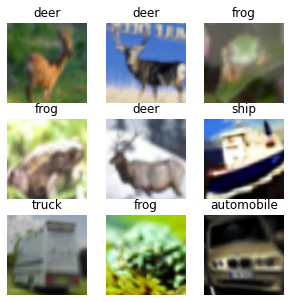

epoch,train_loss,valid_loss,accuracy,time
0,1.198165,0.484172,0.849300,00:20
1,0.599794,0.366214,0.883900,00:18
2,0.455474,0.344462,0.888900,00:18


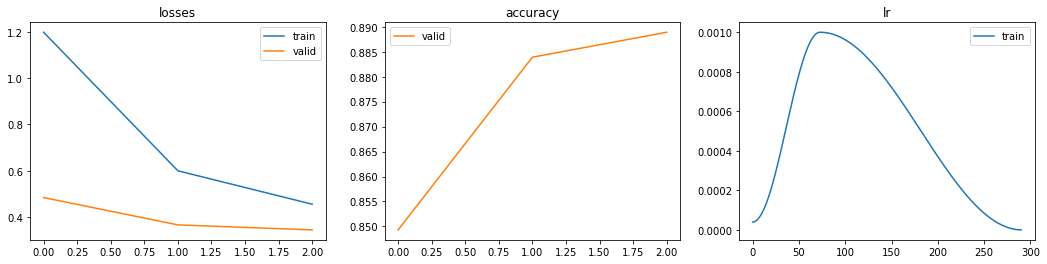

epoch,train_loss,valid_loss,accuracy,time
0,0.429407,0.635080,0.804700,00:21
1,0.310882,0.268715,0.910600,00:20
2,0.178659,0.171025,0.942500,00:20


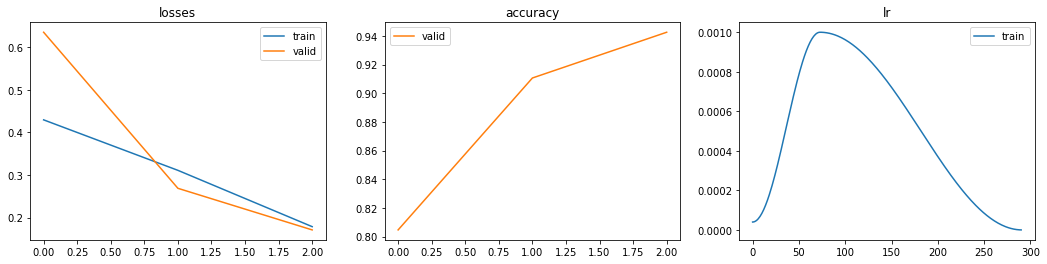

Accuracy (tta) : 0.9531999826431274
Result of 10 times training with 3+3 epochs: [0.9527000188827515, 0.9552000164985657, 0.9538000226020813, 0.9542999863624573, 0.9539999961853027, 0.954800009727478, 0.9542999863624573, 0.9521999955177307, 0.9553999900817871, 0.953499972820282]
Using:  50000 10000 0


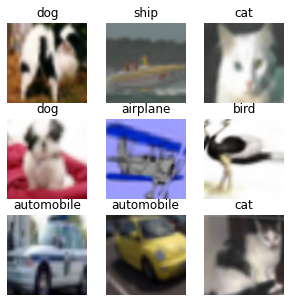

epoch,train_loss,valid_loss,accuracy,time
0,1.884103,0.756242,0.753900,00:18
1,0.868369,0.426130,0.862600,00:18
2,0.521497,0.343721,0.890300,00:18
3,0.396626,0.304444,0.899600,00:18
4,0.337772,0.280373,0.905200,00:18
5,0.300347,0.259288,0.912700,00:18
6,0.285542,0.245497,0.916100,00:18
7,0.265422,0.243297,0.919100,00:18
8,0.262051,0.235604,0.920400,00:17
9,0.259648,0.239163,0.920400,00:18


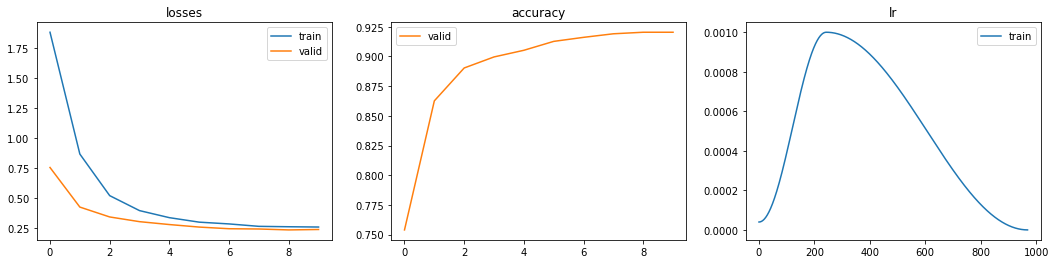

epoch,train_loss,valid_loss,accuracy,time
0,0.284965,0.306431,0.903600,00:20
1,0.335312,0.460222,0.852400,00:21
2,0.330297,0.391235,0.876100,00:20
3,0.280879,0.464582,0.855000,00:21
4,0.232852,0.274358,0.911400,00:20
5,0.179041,0.246506,0.923100,00:21
6,0.135647,0.192890,0.940900,00:21
7,0.086780,0.170249,0.948000,00:21
8,0.058047,0.164124,0.953000,00:20
9,0.047665,0.158735,0.953700,00:21


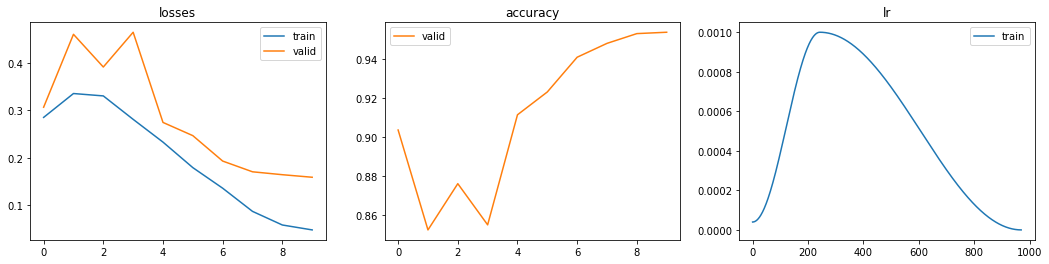

Accuracy (tta) : 0.9628000259399414
Result of 10 times training with 10+10 epochs: [0.9634000062942505, 0.963100016117096, 0.9639999866485596, 0.9642999768257141, 0.963100016117096, 0.9632999897003174, 0.9623000025749207, 0.9631999731063843, 0.9657999873161316, 0.9624000191688538]


In [3]:
#testing with 3 epochs
train_cifar10(cifar10_paths, verbose=True, epochs_per_pass=3)
tta_acc_example3 = [train_cifar10(cifar10_paths, verbose=False, epochs_per_pass=3) for _ in range(10)]
print("Result of 10 times training with 3+3 epochs:", tta_acc_example3)
#testing with 10 epochs
train_cifar10(cifar10_paths, verbose=True, epochs_per_pass=10)
tta_acc_example10 = [train_cifar10(cifar10_paths, verbose=False, epochs_per_pass=10) for _ in range(10)]
print("Result of 10 times training with 10+10 epochs:", tta_acc_example10)

This Accuracy is on par with the current best results at the paperswithcode public leaderboard:

https://paperswithcode.com/sota/image-classification-on-cifar-10

Best comparable entry (ResNet32) has 95.35